In [36]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al 

In [37]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 100        # 시뮬레이션 해상도
nfreq = 100             # 추출할 주파수 개수
design_region_resolution = 50

In [61]:
1/fcen

0.509090909090909

In [ ]:
tal = 0.3
talq3 = 0.06
tandp = 0.06
tito = 0.16
tsio2 = 0.36
tair = 1.6

tpml = 0.5

design_region_width = 5.0       # OLED의 가로/세로 길이
design_region_height = 0.2

al = Al
alq3 = mp.Medium(index = 1.68)
andp = mp.Medium(index = 3.6)
ito = mp.Medium(index = 1.8)
sio2 = mp.Medium(index = 1.45)
SiN = mp.Medium(index = 1.8)
air = mp.Medium(index = 1)

Sy = tal+talq3+tandp+tito+design_region_height+tsio2+tair
Sx = design_region_width + 2*tpml

cell_size = mp.Vector3(Sx, Sy)

boundary_layers = [mp.PML(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

In [39]:
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiN, sio2, grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, Sy/2 - (tair + tsio2 + design_region_height/2)),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)



geometry = [
    # 1) Air 층 (맨 위)
    mp.Block(
        material=air,
        size=mp.Vector3(mp.inf, tair, mp.inf),
        center=mp.Vector3(
            0,
            +Sy/2 - tair/2,  # 전체 맨 위에서 반 두께만큼 아래
            0
        )
    ),

    # 2) SiN (cover‐glass) 층
    mp.Block(
        material=sio2,
        size=mp.Vector3(mp.inf, tsio2, mp.inf),
        center=mp.Vector3(
            0,
            +Sy/2 - (tair + tsio2/2),  # 맨 위 Air 끝 지점에서 반 두께만큼 아래
            0
        )
    ),

    # 3) Design Region (SiO2) 층
    mp.Block(
        material=design_variables,
        size= design_region.size,
        center=design_region.center,
    ),

    # 4) ITO 층
    mp.Block(
        material=ito,
        size=mp.Vector3(mp.inf, tito, mp.inf),
        center=mp.Vector3(
            0,
            +Sy/2 - (tair + tsio2 + design_region_height + tito/2),
            0
        )
    ),

    # 5) aNDP 층
    mp.Block(
        material=andp,
        size=mp.Vector3(mp.inf, tandp, mp.inf),
        center=mp.Vector3(
            0,
            +Sy/2 - (tair + tsio2 + design_region_height + tito + tandp/2),
            0
        )
    ),

    # 6) Alq3 층
    mp.Block(
        material=alq3,
        size=mp.Vector3(mp.inf, talq3, mp.inf),
        center=mp.Vector3(
            0,
            +Sy/2 - (tair + tsio2 + design_region_height + tito + tandp + talq3/2),
            0
        )
    ),

    # 7) Al 층 (맨 아래)
    mp.Block(
        material=Al,
        size=mp.Vector3(mp.inf, tal, mp.inf),
        center=mp.Vector3(
            0,
            +Sy/2 - (tair + tsio2 + design_region_height + tito + tandp + talq3 + tal/2),
            0
        )
    ),
]


In [44]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 5

for i in range(src_num):  # x 방향 루프
    sources.append(
        mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                y = +Sy/2 - (tair + tsio2 + design_region_height + tito + tandp + talq3/2),
                z = 0
            )
        )
    )

sim = []

for i in range(src_num):
    sim.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[sources[i]],
                      extra_materials=[al],)
    )

dft_fields = sim[2].add_dft_fields([mp.Ez], fcen, 0, 1, 
                                   center = mp.Vector3(0, +Sy/2 - (tair + tsio2/2)+tsio2/2+1/fcen),
                                   size = mp.Vector3(design_region_width,0,0), 
                                   yee_gri=True)

In [69]:
i=1

-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1))

-0.8333333333333335

     block, center = (0,0.57,0)
          size (1e+20,1.6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.41,0)
          size (1e+20,0.36,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block

, center = (0,-0.69,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-0.87,0)
          size (1e+20,0.16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.98,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-1.04,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-1.22,0)
          size (1e+20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

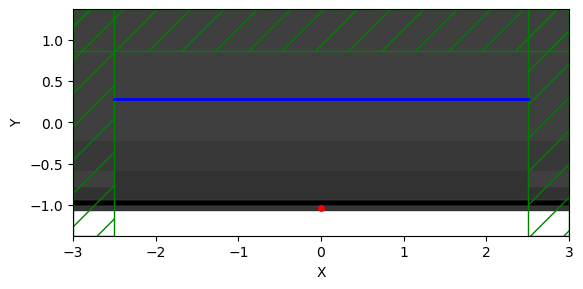

In [45]:
sim[2].plot2D()
    # output_plane = mp.Volume(
    #               center = mp.Vector3(0, Sy/2 - (tair + tsio2 + design_region_height + tito + tandp + talq3/2)), 
    #                 size = mp.Vector3(2,2)))    

In [46]:
nearfield = sim[2].add_near2far(fcen, 0, 1,
                                mp.Near2FarRegion(center=mp.Vector3(0, +Sy/2 - (tair + tsio2/2)+tsio2/2+1/fcen),
                                size = mp.Vector3(design_region_width,0,0)), )

sim[2].run(until_after_sources=mp.stop_when_dft_decayed())
dft_fields_Ez = sim[2].get_dft_array(dft_fields, mp.Ez, 0)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000156879 s
Working in 2D dimensions.
Computational cell is 6 x 2.74 x 0 with resolution 100
     block, center = (0,0.57,0)
          size (1e+20,1.6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.41,0)
          size (1e+20,0.36,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,-0.69,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-0.87,0)
          size (1e+20,0.16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.98,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-1.04,0)
         

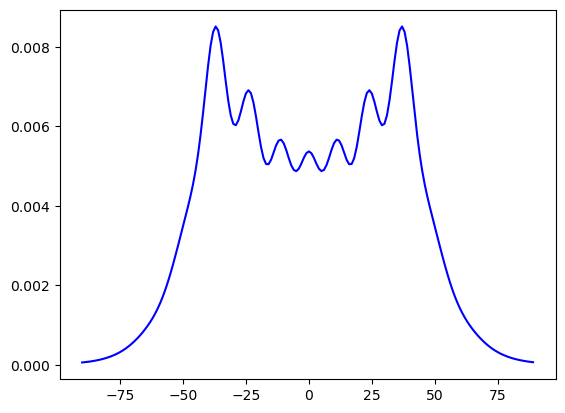

In [88]:
r = 20*1/fcen

npts = 180  # number of points in [0,2*pi) range of angles
angles = math.pi/npts*np.arange(npts)
angles_deg = np.degrees(angles)


E = np.zeros((npts,3),dtype=np.complex128)
H = np.zeros((npts,3),dtype=np.complex128)
for n in range(npts):
    ff = sim[2].get_farfield(nearfield,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n])))
    E[n,:] = [ff[j] for j in range(3)]
    H[n,:] = [ff[j+3] for j in range(3)]

Px = np.real(np.conj(E[:, 1]) * H[:, 2] - np.conj(E[:, 2]) * H[:, 1])
Py = np.real(np.conj(E[:, 2]) * H[:, 0] - np.conj(E[:, 0]) * H[:, 2])
Pr = np.sqrt(np.square(Px) + np.square(Py))

far_flux_circle = np.sum(Pr)*2*np.pi*r/len(Pr)
# plt.xlim(-90, 90)
plt.plot(angles_deg-90, Pr,'b-', )

In [97]:
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# (2-3) rad per unit length → kx 값
kx = 2 * np.pi * kx_cycles    # shape = (N,)

/tmp/ipykernel_1867089/362164059.py:6: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(k_x / k0)      # radians


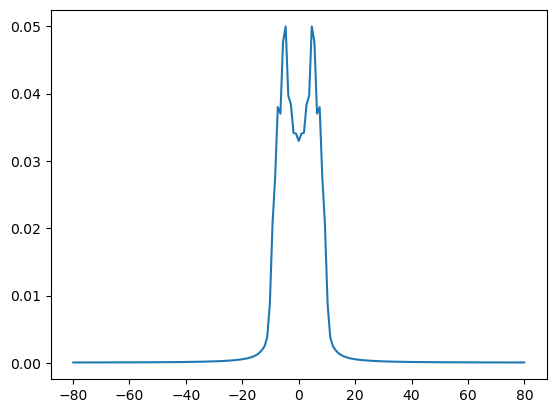

In [111]:
m0_fft = npa.fft.fftshift(npa.fft.fft(dft_fields_Ez)) /len(dft_fields_Ez)
k_x = npa.fft.fftshift(npa.fft.fftfreq(len(m0_fft), 1/resolution))

k0 = 2 * np.pi * fcen       # (rad per unit length)

theta = np.arcsin(k_x / k0)      # radians
degree = np.degrees(theta)

num_index = npa.argmin(np.abs(k_x))

power0=npa.abs(m0_fft)

plt.plot(degree, power0, )
# plt.xlim(-10,10)

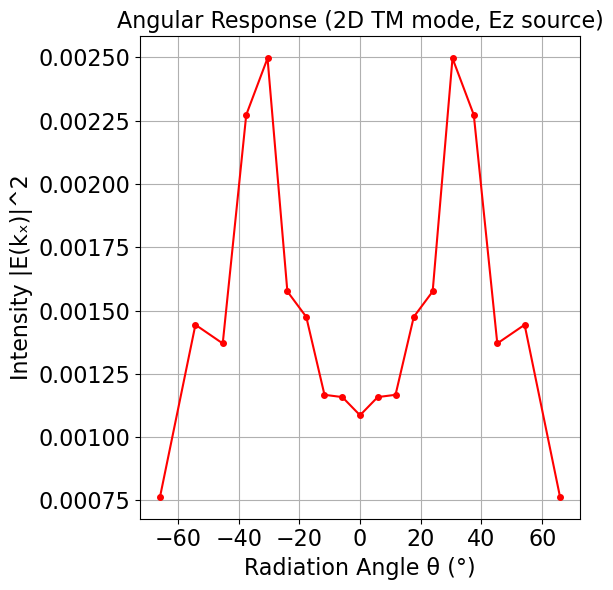

In [109]:
N = len(dft_fields_Ez)
dx = 1.0 / resolution       # (unit length 당 샘플링 간격)
k0 = 2 * np.pi * fcen       # (rad per unit length)

E_k = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N    # shape = (N,)

# (2-2) “cycle per unit length” 단위의 x축 빈도 (shape = (N,))
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# (2-3) rad per unit length → kx 값
kx = 2 * np.pi * kx_cycles    # shape = (N,)

mask = np.abs(kx) <= k0      # k0보다 작은 것들은 evanescent mode로 분류
kx_prop = kx[mask]           # shape = (M,), M <= N

ky_prop = np.sqrt(np.maximum(k0**2 - kx_prop**2, 0.0))   # shape = (M,)

theta = np.arcsin(kx_prop / k0)      # radians
theta_deg = np.degrees(theta)       # degrees

amplitude = np.abs(E_k)              # shape = (N,)
amplitude_prop = amplitude[mask]**2     # 전파 가능 성분만 (shape = (M,))

font_label = 16

plt.figure(figsize=(6, 6))
plt.plot(theta_deg, amplitude_prop, '-ro', markersize=4)
plt.xlabel("Radiation Angle θ (°)", fontsize=font_label)
plt.ylabel("Intensity |E(kₓ)|^2",        fontsize=font_label)
plt.title("Angular Response (2D TM mode, Ez source)", fontsize=font_label)
plt.xticks(fontsize = font_label)
plt.yticks(fontsize = font_label)

plt.grid(True)
# plt.xlim([-43, +43])   # θ ∈ [−90°, +90°] 범위
plt.tight_layout()
plt.show()

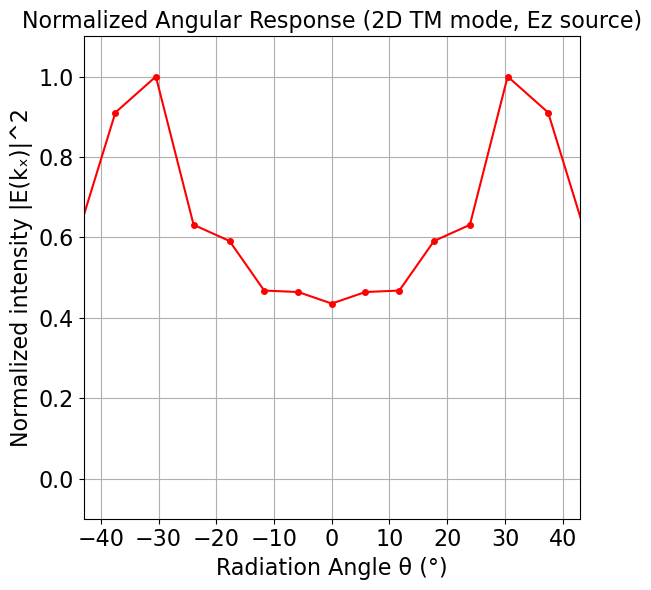

In [48]:
# (Normalization) 최대값으로 나누어 정규화
amplitude_prop_norm = amplitude_prop / max(amplitude_prop)

font_label = 16

plt.figure(figsize=(6, 6))
plt.plot(theta_deg, amplitude_prop_norm, '-ro', markersize=4)
plt.xlabel("Radiation Angle θ (°)", fontsize=font_label)
plt.ylabel("Normalized intensity |E(kₓ)|^2", fontsize=font_label)
plt.title("Normalized Angular Response (2D TM mode, Ez source)", fontsize=font_label)
plt.xticks(fontsize=font_label)
plt.yticks(fontsize=font_label)

plt.grid(True)
plt.xlim([-43, +43])   # 필요에 따라 방사각 범위를 제한 가능
plt.ylim([-0.1,1.1])
plt.tight_layout()
plt.show()


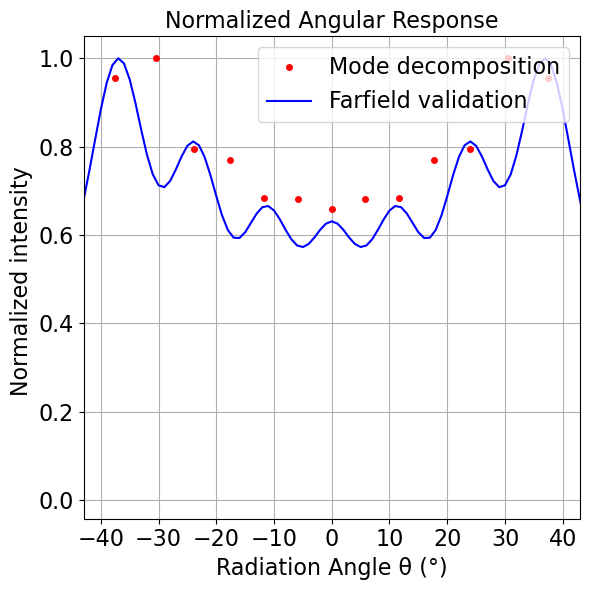

In [23]:
amplitude_prop_norm = amplitude_prop / np.max(amplitude_prop)

font_label = 16

plt.figure(figsize=(6, 6))
plt.plot(theta_deg, amplitude_prop_norm, 'ro', markersize=4, label = 'Mode decomposition')
plt.xlabel("Radiation Angle θ (°)", fontsize=font_label)
plt.ylabel("Normalized intensity ", fontsize=font_label)
plt.title("Normalized Angular Response", fontsize=font_label)
plt.xticks(fontsize=font_label)
plt.yticks(fontsize=font_label)

plt.grid(True)
plt.xlim([-43, +43])   # 필요에 따라 방사각 범위를 제한 가능
# plt.ylim([0.5, 1.01])   # 필요에 따라 방사각 범위를 제한 가능
plt.tight_layout()
plt.plot(angles_deg-90, Pr/max(Pr),'b-', label = 'Farfield validation')
plt.legend(fontsize = font_label, loc = 'upper right')
plt.show()

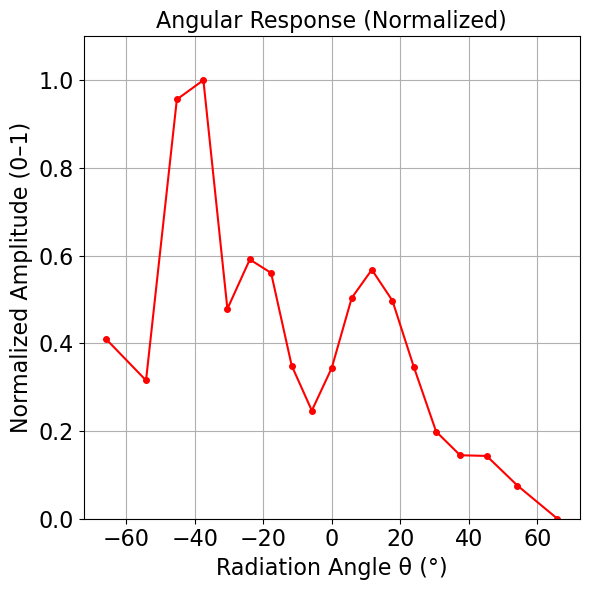

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# (1) 기존에 얻은 데이터
#   - theta_deg     : angle array (degree 단위)
#   - amplitude_prop: 해당 각도에서의 진폭 스펙트럼 (절댓값)
# 예시: amplitude_prop = np.abs(E_k[mask])

# (2) 최솟값, 최댓값 계산
A_min = np.min(amplitude_prop)
A_max = np.max(amplitude_prop)

# (3) 0~1 구간으로 정규화
A_norm = (amplitude_prop - A_min) / (A_max - A_min)

# (4) 결과 플롯
plt.figure(figsize=(6,6))
plt.plot(theta_deg, A_norm, '-ro', markersize=4)
plt.xlabel("Radiation Angle θ (°)", fontsize=font_label)
plt.ylabel("Normalized Amplitude (0–1)", fontsize=font_label)
plt.title("Angular Response (Normalized)", fontsize=font_label)

plt.xticks(fontsize = font_label)
plt.yticks(fontsize = font_label)

plt.grid(True)
# plt.xlim([-45, +45])
plt.ylim([0, 1.1])
plt.tight_layout()
plt.show()


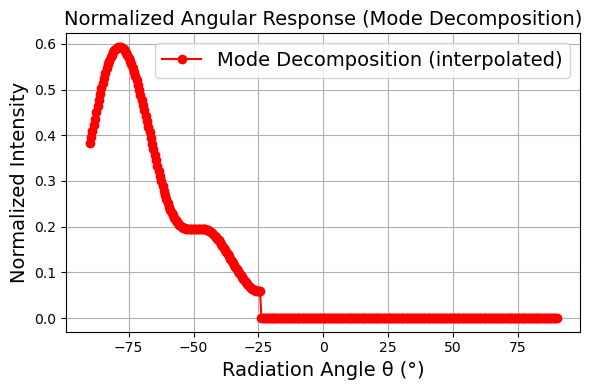

In [100]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- (1) 기존에 정의된 변수들 ---
# dft_fields_Ez    : 길이 N의 1D numpy array (공간 DFT 필드값, 복소수)
# resolution       : DFT 샘플링 해상도 (pixels per μm)
# fcen             : 중심 주파수 (1/μm 단위)
# (사전) sim, nearfield 등은 이미 정의되어 있다고 가정합니다.

# (1-1) 기본 상수/계산
N = len(dft_fields_Ez)
dx = 1.0 / resolution               # μm당 샘플 간격
k0 = 2 * np.pi * fcen               # rad/μm

# (1-2) 공간 FFT 수행
E_k = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N   # shape = (N,)

# (1-3) kx 계산 (rad/μm)
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))   # [cycles/μm]
kx = 2 * np.pi * kx_cycles                             # [rad/μm]

# (1-4) 전파 가능한 성분만 골라내기
mask = np.abs(kx) <= k0
kx_prop = kx[mask]                  # (M,)
amplitude = np.abs(E_k)             # (N,)
amplitude_prop = amplitude[mask]    # (M,)

# (1-5) 방사각 θ 계산 (원래 정의: arcsin(kx/k0))
theta_rad_mode = np.arcsin(kx_prop / k0)    # radians, [-π/2, +π/2]
theta_deg_mode = np.degrees(theta_rad_mode) # degrees, [-90°, +90°]

# (1-6) θ 기준을 Far-field와 동일하게 옮기기 (θ_mode=90° → 정면(0°), θ_mode=0° → 우측(+90°))
# 예: mode 기준 0°(→x축+)를 far-field 기준으로 –90° 로 보려면
theta_deg_mode_shifted = theta_deg_mode - 90   # → 범위: [-180°, 0°] 
# 또는 아래처럼 쓰면 좋은데, 일반적으로 두 그래프가 –90°~+90°만 비교할 거라 아래로 제한
# theta_deg_mode_shifted = theta_deg_mode - 90

# (1-7) 세기(Intensity) 값: |E_k|^2
power_prop = amplitude_prop**2

# (1-8) 정규화(Normalization)
power_prop_norm = power_prop / np.max(power_prop)

# (1-9) 균일 θ grid 생성 (예: –90°~+90°를 360개 점으로)
theta_uniform = np.linspace(-90, 90, 360)   # 0.5° 간격
# 모드 디컴포지션 데이터는 비균일한 θ 지점에 있으므로, 보간(interpolate) 수행
# interpolation 함수를 만들 때, M개의 점이 “내림차순” 혹은 “오름차순” 정렬되어 있는지 확인
sort_idx = np.argsort(theta_deg_mode_shifted)
theta_sorted = theta_deg_mode_shifted[sort_idx]
power_sorted = power_prop_norm[sort_idx]

interp_fun = interp1d(theta_sorted, power_sorted, kind='cubic',
                      fill_value=0.0, bounds_error=False)

power_interp = interp_fun(theta_uniform)   # 길이 360짜리, 균일 그리드 위 파워

# --- (2) 플롯 ---
font_label = 14
plt.figure(figsize=(6,4))
plt.plot(theta_uniform, power_interp, 'ro-', label='Mode Decomposition (interpolated)')
plt.xlabel('Radiation Angle θ (°)', fontsize=font_label)
plt.ylabel('Normalized Intensity',    fontsize=font_label)
plt.title('Normalized Angular Response (Mode Decomposition)', fontsize=font_label)
plt.grid(True)
plt.legend(fontsize=font_label)
plt.tight_layout()
plt.show()


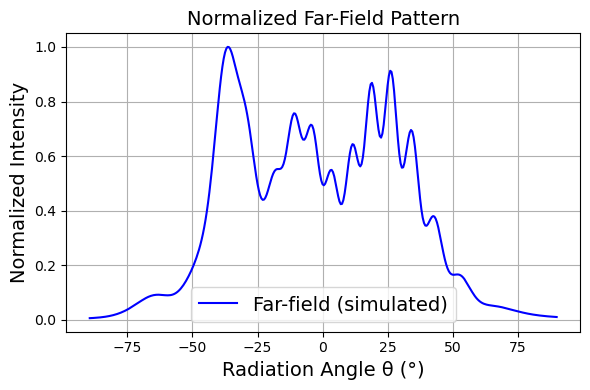

In [90]:
import numpy as np
import math
import matplotlib.pyplot as plt

# --- (1) 시뮬레이션 및 near-to-far 모니터 정의 (이미 만들어져 있다고 가정) ---
# sim[4], nearfield (mp.Near2FarRegion) 등은 이미 정의된 상태

# (1-1) Far-field 평가 거리 및 샘플 갯수
r = 20 * 1/fcen         # 중심 파장(lambda0)의 20배 거리
npts = 360              # 360개 점으로 0~π 라디안 샘플링

# (1-2) 각도(φ) 정의: 0~π radian 구간
phi = math.pi / npts * np.arange(npts)  # radians, [0, π)
phi_deg = np.degrees(phi)               # degrees, [0°, 180°)

# (1-3) Far-field E/H 배열 초기화
E = np.zeros((npts, 3), dtype=np.complex128)
H = np.zeros((npts, 3), dtype=np.complex128)

for i in range(npts):
    θ_rad = phi[i]
    ff = sim[4].get_farfield(
        nearfield,
        mp.Vector3(r * math.cos(θ_rad), r * math.sin(θ_rad))
    )
    E[i, :] = [ff[j]   for j in range(3)]
    H[i, :] = [ff[j+3] for j in range(3)]

# (1-4) Poynting 벡터 크기 Pr 계산 (세기 Intensity)
Px = np.real(np.conj(E[:,1]) * H[:,2] - np.conj(E[:,2]) * H[:,1])
Py = np.real(np.conj(E[:,2]) * H[:,0] - np.conj(E[:,0]) * H[:,2])
Pr = np.sqrt(Px**2 + Py**2)         # (npts,) 배열

# (1-5) θ (모드 디컴포지션과 1:1 매칭)
#      φ_deg=90 → θ=0, φ_deg=0→θ=+90, φ_deg=180→θ=-90
theta_deg_FF = 90.0 - phi_deg       # (npts,) 배열, 범위: [-90°, +90°]

# (1-6) Intensity 정규화
Pr_norm = Pr / np.max(Pr)

# --- (2) 보간 없이, 점 자체를 표시하기 위함 ---
#      만약 모드 디컴포지션과 같은 균일 θ grid(예: [-90°, +90°] 360개 점)만 추출하려면
#      아래같이 어차피 phi_deg가 0~180, theta_deg_FF가 -90~+90를 균일 분할함.
#      사실 이미 theta_deg_FF는 균일 간격(0.5°)을 갖기 때문에, 보간 불필요.

# --- (3) 플롯 ---
font_label = 14

plt.figure(figsize=(6,4))
plt.plot(theta_deg_FF, Pr_norm, 'b-', label='Far-field (simulated)')
plt.xlabel('Radiation Angle θ (°)', fontsize=font_label)
plt.ylabel('Normalized Intensity',    fontsize=font_label)
plt.title('Normalized Far-Field Pattern', fontsize=font_label)
plt.grid(True)
plt.legend(fontsize=font_label)
plt.tight_layout()
plt.show()


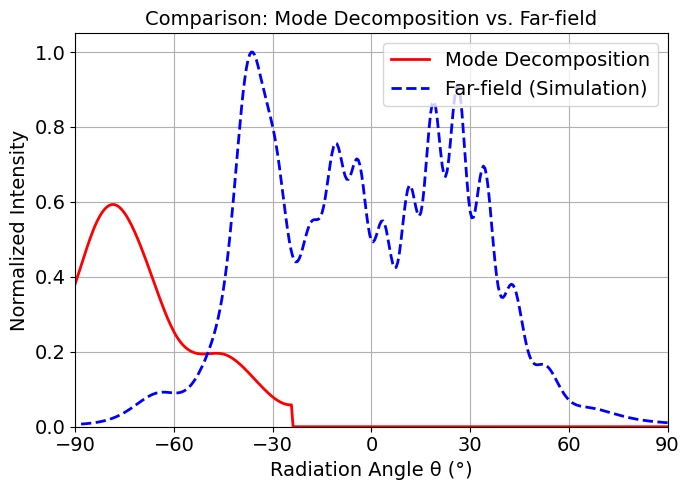

In [91]:
import matplotlib.pyplot as plt

# (A) 모드 디컴포지션 쪽: 
#    'power_interp'   : 모드 디컴포지션 → 균일 θ grid 보간 결과 (길이 360)
#    'theta_uniform'  : [-90, +90] 균일 θ grid (길이 360)

# (B) Far-field 쪽:
#    'Pr_norm'        : Far-field 결과 정규화 (길이 360)
#    'theta_deg_FF'   : [-90, +90] 균일 θ grid (길이 360)

font_label = 14
plt.figure(figsize=(7,5))

# 모드 디컴포지션 (빨간 실선)
plt.plot(theta_uniform, power_interp,
         color='red', linestyle='-', linewidth=2, label='Mode Decomposition')

# Far-field (파란 점선)
plt.plot(theta_deg_FF, Pr_norm,
         color='blue', linestyle='--', linewidth=2, label='Far-field (Simulation)')

plt.xlabel('Radiation Angle θ (°)', fontsize=font_label)
plt.ylabel('Normalized Intensity',    fontsize=font_label)
plt.title('Comparison: Mode Decomposition vs. Far-field', fontsize=font_label)
plt.xlim(-90, 90)
plt.ylim(0, 1.05)
plt.xticks(np.arange(-90, 91, 30), fontsize=font_label)
plt.yticks(np.linspace(0,1,6),           fontsize=font_label)
plt.grid(True)
plt.legend(fontsize=font_label, loc='upper right')
plt.tight_layout()
plt.show()


     block, center = (0,0.57,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.21,0)
          size (1e+20,0.36,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,-0.49,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-0.67,0)
          size (1e+20,0.16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.78,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-0.84,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-1.

<Axes: xlabel='X', ylabel='Y'>

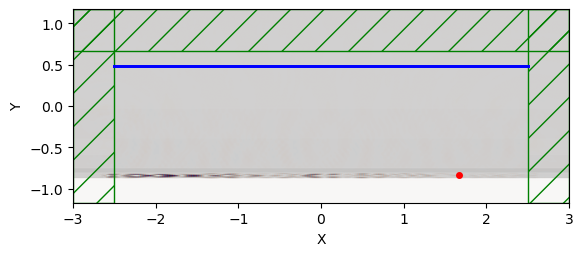

In [85]:
# sim[2].reset_meep()
# sim[2].run(until=1)
sim[4].plot2D(fields = mp.Ez)

/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


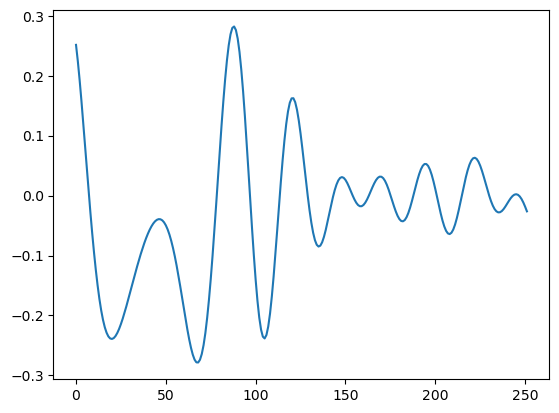

In [208]:
plt.plot(dft_fields_Ez)

(-18.84955592153876, 18.84955592153876)

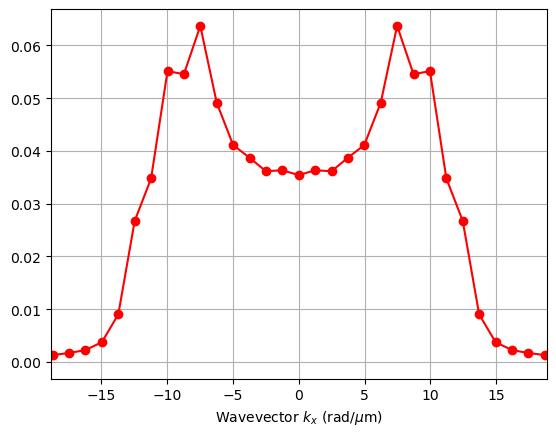

In [121]:
# 1) 샘플 포인트 개수 N 확인
N = len(dft_fields_Ez)
assert N == design_region_width * resolution + 2, "샘플 포인트 개수 불일치!"

# 2) FFT & 정규화 (1/N)
m0ez_fft = np.fft.fftshift(np.fft.fft(dft_fields_Ez)) / N

# 3) kx 축 생성 (cycle/μm 단위 → rad/μm 단위로 변환하려면 *2π)
kx_cycle = np.fft.fftshift(np.fft.fftfreq(N, d=1/resolution))  # cycle/μm
kx = 2 * np.pi * kx_cycle   # → rad/μm 단위

plt.plot(kx, np.abs(m0ez_fft), "-ro")
plt.xlabel(r"Wavevector $k_x$ (rad/$\mu$m)")
plt.grid()
plt.xlim([-3 * 2*np.pi, 3 * 2*np.pi])  # 만약 rad/μm 단위로 보고 싶으면


(-3.0, 3.0)

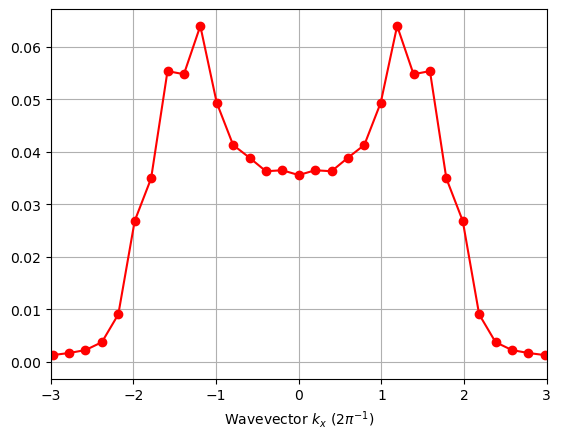

In [38]:
# 0번째 dipole
m0ez_fft=npa.fft.fftshift(npa.fft.fft(dft_fields_Ez))/(design_region_width*resolution+1)
kx = npa.fft.fftshift(np.fft.fftfreq(len(dft_fields_Ez), 1 / resolution))

plt.plot(kx,np.abs(m0ez_fft),"-ro")
plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
plt.grid()
plt.xlim([-3,3])


(-3.0, 3.0)

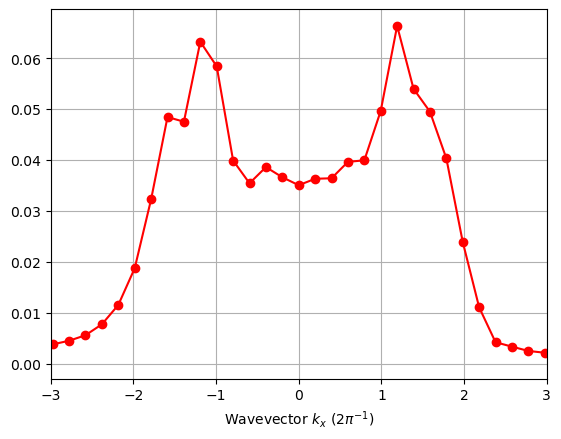

In [30]:
# 1번째 dipole
m0ez_fft=npa.fft.fftshift(npa.fft.fft(dft_fields_Ez))/(design_region_width*resolution+1)
kx = npa.fft.fftshift(np.fft.fftfreq(len(dft_fields_Ez), 1 / resolution))

plt.plot(kx,np.abs(m0ez_fft),"-ro")
plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
plt.grid()
plt.xlim([-3,3])


(-3.0, 3.0)

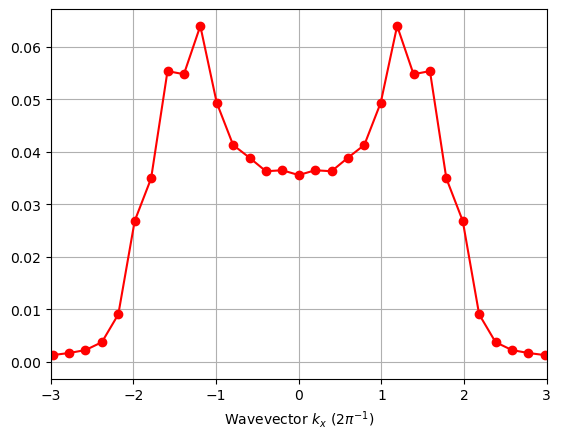

In [36]:
# 2번째 dipole
m0ez_fft=npa.fft.fftshift(npa.fft.fft(dft_fields_Ez))/(design_region_width*resolution+1)
kx = npa.fft.fftshift(np.fft.fftfreq(len(dft_fields_Ez), 1 / resolution))

plt.plot(kx,np.abs(m0ez_fft),"-ro")
plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
plt.grid()
plt.xlim([-3,3])


(-3.0, 3.0)

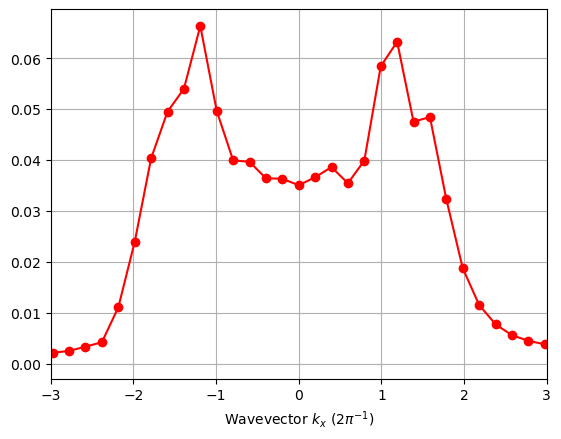

In [42]:
# 3번째 dipole
m0ez_fft=npa.fft.fftshift(npa.fft.fft(dft_fields_Ez))/(design_region_width*resolution+1)
kx = npa.fft.fftshift(np.fft.fftfreq(len(dft_fields_Ez), 1 / resolution))

plt.plot(kx,np.abs(m0ez_fft),"-ro")
plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
plt.grid()
plt.xlim([-3,3])


(-3.0, 3.0)

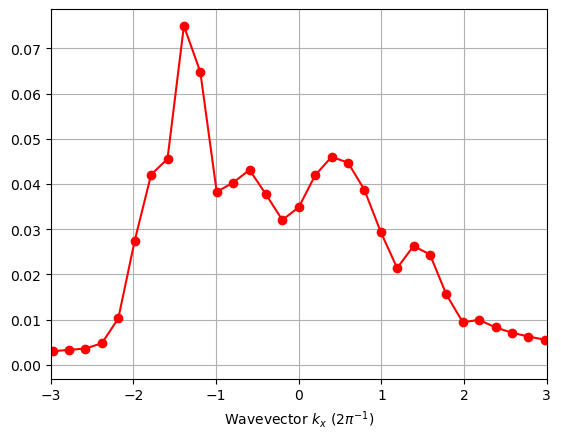

In [50]:
# 4번째 dipole
m0ez_fft=npa.fft.fftshift(npa.fft.fft(dft_fields_Ez))/(design_region_width*resolution+1)
kx = npa.fft.fftshift(np.fft.fftfreq(len(dft_fields_Ez), 1 / resolution))

plt.plot(kx,np.abs(m0ez_fft),"-ro")
plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
plt.grid()
plt.xlim([-3,3])


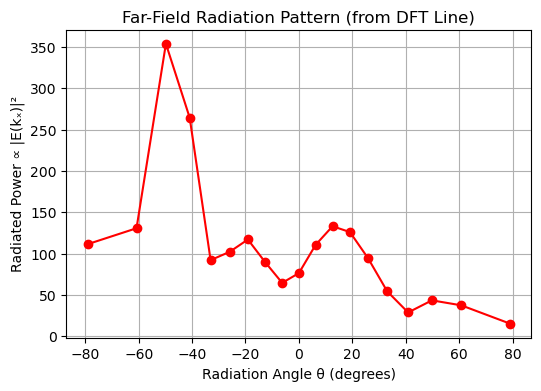

In [49]:
Ez_kx = npa.fft.fftshift(npa.fft.fft(dft_fields_Ez))
kx = npa.fft.fftshift(npa.fft.fftfreq(len(dft_fields_Ez), d=1/resolution)) * 2*npa.pi  # rad/μm

k0 = 2*npa.pi / 0.55


# 방사 가능한 각도 추출: |kx| < k0 인 부분만
valid = npa.abs(kx) <= k0
kx_valid = kx[valid]
Ez_valid = Ez_kx[valid]

# 각도 계산
theta = npa.arcsin(kx_valid / k0) * 180 / npa.pi

# 방사 패턴 (복사 전력)
power = npa.abs(Ez_valid)**2

# Plot
plt.figure(figsize=(6,4))
plt.plot(theta, power, '-or')
plt.xlabel("Radiation Angle θ (degrees)")
plt.ylabel("Radiated Power ∝ |E(kₓ)|²")
plt.grid()
plt.title("Far-Field Radiation Pattern (from DFT Line)")
plt.show()

In [601]:
monitor_position, monitor_size = mp.Vector3(0,Sy/2 - (tair + tsio2/2)+tsio2/2+1/fcen), mp.Vector3(design_region_width,0)

FourierFields = []

for i in range(src_num):
    FourierFields.append(
        mpa.FourierFields(sim[i],
                          mp.Volume(center=monitor_position,size=monitor_size),
                          mp.Ez,yee_grid=True)
        )

ob_list = []

for i in range(src_num):
    ob_list.append(FourierFields[i])

def M0(m0ez):
    m0ez_fft=npa.fft.fftshift(npa.fft.fft(m0ez[0,:]))
    length=len(m0ez_fft)
    kx = npa.fft.fftshift(npa.fft.fftfreq(len(m0ez_fft), 1 / resolution))
    num_index=npa.argmin(np.abs(kx))

    power0=npa.abs(m0ez_fft[num_index])

    return - power0

opt = []
for i in range(src_num):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[M0],
        objective_arguments=[ob_list[i]],
        design_regions=[design_region],
        frequencies=[fcen],
        maximum_run_time=100,
    ))

     block, center = (0,0.57,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.21,0)
          size (1e+20,0.36,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,-0.49,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-0.67,0)
          size (1e+20,0.16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.78,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-0.84,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-1.

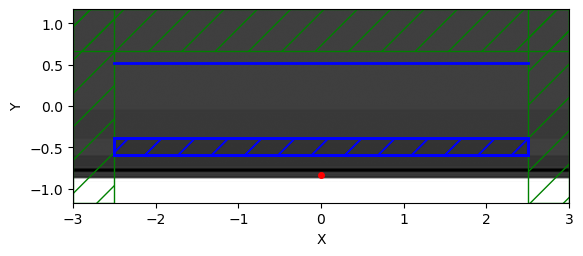

In [602]:
opt[2].plot2D(True)

In [ ]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

